In [1]:
from google.cloud import bigquery

In [2]:
bq = bigquery.Client()

In [3]:
%load_ext google.cloud.bigquery

In [4]:
# practice data 1
import pandas as pd
import numpy as np
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = df["x1"] + df["x2"] + np.random.rand(len(df))

In [5]:
df.head(3)

,x1,x2,y
0,9.0,0.0,9.328812
1,7.0,0.0,7.230137
2,8.0,2.0,10.909078


In [10]:
df.to_parquet("test.parquet")

In [9]:
# gbq: Google BigQuery
df.to_gbq("cs544-f23.test1.samp1", if_exists="replace")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 2970.47it/s]


In [17]:
%%bigquery
CREATE OR REPLACE TABLE cs544-f23.test1.traintest

AS

SELECT *, rand()<0.25 AS test
FROM cs544-f23.test1.samp1

Query is running:   0%|          |

""


In [23]:
%%bigquery
CREATE OR REPLACE MODEL `cs544-f23.test1.lr`
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

SELECT x1,x2,y
FROM test1.traintest
WHERE NOT test

Query is running:   0%|          |

""


In [24]:
%%bigquery
SELECT *
FROM ML.WEIGHTS(MODEL `cs544-f23.test1.lr`)

Query is running:   0%|          |

Downloading:   0%|          |

,processed_input,weight,category_weights
0,x1,1.010272,[]
1,x2,1.043084,[]
2,__INTERCEPT__,0.383653,[]


In [26]:
%%bigquery
SELECT *
FROM ML.PREDICT(MODEL `cs544-f23.test1.lr`, (
    SELECT x1,x2,y
    FROM test1.traintest
    WHERE test
))

Query is running:   0%|          |

Downloading:   0%|          |

,predicted_y,x1,x2,y
0,0.383653,0.0,0.0,0.520344
1,4.424741,4.0,0.0,4.798193
2,4.424741,4.0,0.0,4.865165
3,5.435013,5.0,0.0,5.497015
4,5.435013,5.0,0.0,5.699165
5,6.445285,6.0,0.0,6.340446
6,6.445285,6.0,0.0,6.616464
7,6.445285,6.0,0.0,6.787285
8,8.465829,8.0,0.0,8.651724
9,9.476101,9.0,0.0,9.869799


In [29]:
%%bigquery df
SELECT *
FROM ML.EVALUATE(MODEL `cs544-f23.test1.lr`, (
    SELECT x1,x2,y
    FROM test1.traintest
    WHERE test
))

Query is running:   0%|          |

Downloading:   0%|          |

In [30]:
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.24607,0.082184,0.003622,0.264152,0.989435,0.98966


In [31]:
df.at[0,"r2_score"]

0.989434810369679

# Transformers

In [32]:
df = pd.DataFrame({"x1": np.random.randint(0, 10, 100).astype(float), 
                   "x2": np.random.randint(0, 3, 100).astype(float)})
df["y"] = 2 * df["x1"] ** 2 - 3 * df["x2"] + np.random.rand(len(df))
df.head()

,x1,x2,y
0,7.0,0.0,98.439363
1,9.0,2.0,156.118874
2,7.0,1.0,95.031526
3,7.0,1.0,95.049035
4,7.0,2.0,92.638904


In [33]:
df.to_parquet("tbl1.parquet")

In [34]:
%%bigquery
CREATE OR REPLACE MODEL `cs544-f23.test1.m1`
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

SELECT x1,x2,y
FROM test1.tbl1

Query is running:   0%|          |

""


In [35]:
%%bigquery df
SELECT *
FROM ML.EVALUATE(MODEL `cs544-f23.test1.m1`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

In [36]:
df

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,13.560731,226.625653,0.126128,13.856188,0.930985,0.930985


In [39]:
%%bigquery
SELECT x1,POWER(x1,2) as x1_2,x2,POWER(x2,2) as x2_2,y
FROM test1.tbl1
LIMIT 5

Query is running:   0%|          |

Downloading:   0%|          |

,x1,x1_2,x2,x2_2,y
0,0.0,0.0,0.0,0.0,0.297422
1,0.0,0.0,0.0,0.0,0.470423
2,0.0,0.0,0.0,0.0,0.517699
3,0.0,0.0,0.0,0.0,0.078928
4,0.0,0.0,0.0,0.0,0.226754


In [40]:
%%bigquery
CREATE OR REPLACE MODEL `cs544-f23.test1.m2`
TRANSFORM(x1,POWER(x1,2) as x1_2,x2,POWER(x2,2) as x2_2,y)
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])

AS

SELECT x1,x2,y
FROM test1.tbl1

Query is running:   0%|          |

""


In [41]:
%%bigquery
SELECT *
FROM
ML.EVALUATE(MODEL `cs544-f23.test1.m2`, (
    SELECT x1,x2,y
    FROM test1.tbl1
))

Query is running:   0%|          |

Downloading:   0%|          |

,mean_absolute_error,mean_squared_error,mean_squared_log_error,median_absolute_error,r2_score,explained_variance
0,0.259063,0.0908,0.002096,0.27176,0.999972,0.999972


In [42]:
# practice data 2
df = pd.DataFrame({"x1": np.random.choice(["A", "B", "C"], 100), 
                   "x2": np.random.randint(0, 10, 100).astype(float)})
df["y"] = df["x1"].map({"A":1, "B":5, "C":15}) + 2 * df["x2"] + np.random.rand(len(df))
df.head(3)

,x1,x2,y
0,B,7.0,19.787481
1,A,6.0,13.448303
2,A,2.0,5.293545


In [43]:
df.to_parquet("tbl2.parquet")

In [46]:
%%bigquery
CREATE OR REPLACE MODEL test1.m3
OPTIONS(model_type="LINEAR_REG", INPUT_LABEL_COLS=["y"])
AS
SELECT * FROM test1.tbl2

Query is running:   0%|          |

""


In [48]:
%%bigquery df
SELECT *
FROM
ML.WEIGHTS(MODEL test1.m3)

Query is running:   0%|          |

Downloading:   0%|          |

In [55]:
weights = pd.DataFrame(df.set_index("processed_input").at["x1", "category_weights"].tolist())
weights

,category,weight
0,C,9.943961
1,A,-4.041882
2,B,0.000000


<Axes: xlabel='category'>

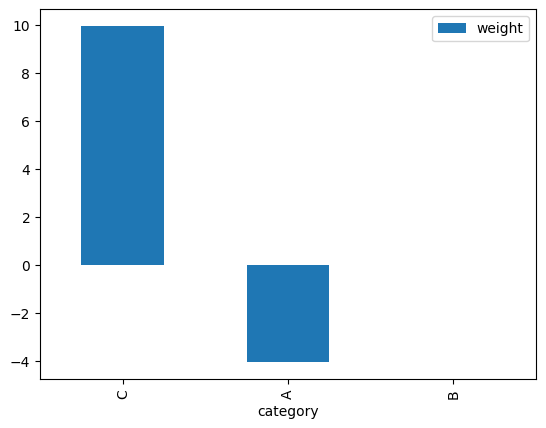

In [57]:
weights.set_index("category").plot.bar()